# Hotel Cancelation

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
hotel_booking_dataset = pd.read_csv("hotel_bookings.csv")
copy_hotel_booking_dataset = hotel_booking_dataset.copy()
features_array = hotel_booking_dataset.columns

In [4]:
print(hotel_booking_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
hotel_booking_dataset

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.00,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.00,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.00,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.00,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [6]:
for i in range(len(features_array)):
    if hotel_booking_dataset[features_array[i]].isnull().any():
        missing_value = hotel_booking_dataset[features_array[i]].isnull().sum()
        print(f"Column '{features_array[i]}' contains {missing_value} null values.")

Column 'children' contains 4 null values.
Column 'country' contains 488 null values.
Column 'agent' contains 16340 null values.
Column 'company' contains 112593 null values.


In [7]:
hotel_booking_dataset["children"].fillna(value=hotel_booking_dataset["children"].mode()[0],inplace=True)
hotel_booking_dataset['childzren'] = hotel_booking_dataset['children'].astype('int32')
hotel_booking_dataset['country'].fillna("Unknown",inplace=True)
hotel_booking_dataset['company'].fillna(0,inplace=True)
hotel_booking_dataset['agent'].fillna(0,inplace=True)

In [8]:
adr_mean = hotel_booking_dataset['adr'].mean()
hotel_booking_dataset.loc[hotel_booking_dataset['adr'] == 0,'adr'] = adr_mean

stay_in_week_night_mode = hotel_booking_dataset['stays_in_week_nights'].mode()[0]
hotel_booking_dataset.loc[((hotel_booking_dataset['stays_in_week_nights'] == 0) & (hotel_booking_dataset['stays_in_weekend_nights'] == 0)),'stays_in_week_nights'] = stay_in_week_night_mode

In [9]:
max_lead_time = hotel_booking_dataset['lead_time'].max()
min_lead_time = hotel_booking_dataset['lead_time'].min()

max_adr = hotel_booking_dataset['adr'].max()
min_adr = hotel_booking_dataset['adr'].min()

hotel_booking_dataset['lead_time'] = (hotel_booking_dataset['lead_time'] - min_lead_time)/(max_lead_time-min_lead_time)
hotel_booking_dataset['adr'] = (hotel_booking_dataset['adr'] - min_lead_time)/(max_lead_time-min_lead_time)

In [10]:
def days_since_1Jan(day, month):
    days_in_month = {
        "january": 31,
        "february": 28,
        "march": 31,
        "april": 30,
        "may": 31,
        "june": 30,
        "july": 31,
        "august": 31,
        "september": 30,
        "october": 31,
        "november": 30,
        "december": 31
    }

    month = month.lower()

    days_count = 0
    for m, days in days_in_month.items():
        if m == month:
            break
        days_count += days

    days_count += (day - 1)

    return days_count 

In [11]:
arr1 = []
for i in range(len(hotel_booking_dataset)):
    arr1.append(days_since_1Jan(hotel_booking_dataset.iloc[i, 6], hotel_booking_dataset.iloc[i, 4]) / 365)
hotel_booking_dataset['arrival_date'] = arr1

hotel_booking_dataset['stays_in_days'] = hotel_booking_dataset['stays_in_week_nights'] + hotel_booking_dataset['stays_in_weekend_nights']

hotel_booking_dataset['room_changed'] = hotel_booking_dataset['reserved_room_type'] != hotel_booking_dataset['assigned_room_type']

hotel_booking_dataset['have_previously_cancelled'] = hotel_booking_dataset['previous_cancellations'] >= 1

hotel_booking_dataset['person_type'] = 'other'
hotel_booking_dataset.loc[(hotel_booking_dataset['adults'] == 2) & (hotel_booking_dataset['children'] == 0) & (hotel_booking_dataset['babies'] == 0), 'person_type'] = 'couple'
hotel_booking_dataset.loc[(hotel_booking_dataset['adults'] == 1) & (hotel_booking_dataset['children'] == 0) & (hotel_booking_dataset['babies'] == 0), 'person_type'] = 'single'
hotel_booking_dataset.loc[((hotel_booking_dataset['adults'] == 3) & (hotel_booking_dataset['children'] == 0) & (hotel_booking_dataset['babies'] == 0)) | 
                          ((hotel_booking_dataset['adults'] == 2) & (hotel_booking_dataset['children'] == 1) & (hotel_booking_dataset['babies'] == 0)) | 
                          ((hotel_booking_dataset['adults'] == 2) & (hotel_booking_dataset['children'] == 2) & (hotel_booking_dataset['babies'] == 0)) | 
                          ((hotel_booking_dataset['adults'] == 2) & (hotel_booking_dataset['children'] == 0) & (hotel_booking_dataset['babies'] == 1)), 'person_type'] = 'family'

copy_hotel_booking_dataset_7 = hotel_booking_dataset.copy()

hotel_booking_dataset.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,childzren,arrival_date,stays_in_days,room_changed,have_previously_cancelled,person_type
0,Resort Hotel,0,0.46,2015,July,27,1,0,2,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.00,0.00,0,Transient,0.14,0,0,Check-Out,2015-07-01,0,0.50,2,False,False,couple
1,Resort Hotel,0,1.00,2015,July,27,1,0,2,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.00,0.00,0,Transient,0.14,0,0,Check-Out,2015-07-01,0,0.50,2,False,False,couple
2,Resort Hotel,0,0.01,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.00,0.00,0,Transient,0.10,0,0,Check-Out,2015-07-02,0,0.50,1,True,False,single
3,Resort Hotel,0,0.02,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,0.00,0,Transient,0.10,0,0,Check-Out,2015-07-02,0,0.50,1,False,False,single
4,Resort Hotel,0,0.02,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,0.00,0,Transient,0.13,0,1,Check-Out,2015-07-03,0,0.50,2,False,False,couple


In [12]:
hotel_booking_dataset = hotel_booking_dataset.drop(columns=['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies','reservation_status', 'deposit_type','reservation_status_date'])
new_feature_array = hotel_booking_dataset.columns
hotel_booking_dataset.head(10)
hotel_booking_dataset_before_onehot = hotel_booking_dataset.copy()

In [13]:
str_feature = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'customer_type', 'country']
encoded_features_df = pd.get_dummies(hotel_booking_dataset[str_feature], drop_first=True)
hotel_booking_dataset = hotel_booking_dataset.drop(columns=str_feature)
hotel_booking_dataset = pd.concat([hotel_booking_dataset, encoded_features_df], axis=1)

In [14]:
hotel_booking_dataset.shape

(119390, 238)

In [15]:
def gini_index(dataset, class_index,n):
    features = dataset.drop(columns=dataset.columns[class_index])
    label = dataset.iloc[:, class_index].squeeze()

    gini_indices = {}

    for feature_name in features.columns:
        feature = dataset[feature_name]
        total_count = dataset.shape[0]
    
        value_counts = pd.crosstab(feature, label)
    
        gini_index_of_sum = 0
    
        for values in value_counts.index:
            feature_value_counts = value_counts.loc[values]
            feature_total = feature_value_counts.sum()
        
            gini_value = 1 - sum((count / feature_total) ** 2 for count in feature_value_counts)
            gini_index_of_sum += gini_value * (feature_total / total_count)
    
        gini_indices[feature_name] = gini_index_of_sum
    
    sorted_gini = sorted(gini_indices.items(), key=lambda item: item[1])

    top_n_features = sorted_gini[:n]
    top_n_feature_names = [feature_name for feature_name,gini in top_n_features]

    reduced_dataset = dataset[top_n_feature_names]

    return reduced_dataset

### Following Question

In [16]:
copy_hotel_booking_dataset['is_canceled'].value_counts()

is_canceled
0    75166
1    44224
Name: count, dtype: int64

In [17]:
count_Resort_Hotel = 0
count_City_Hotel = 0

for value in copy_hotel_booking_dataset['hotel']:
    if value == "Resort Hotel":
        count_Resort_Hotel += 1
    else:
        count_City_Hotel += 1
print(f"The number of City Hotel is {count_City_Hotel}")
print(f"The number of Resort Hotel is{count_Resort_Hotel}")

size2 = [count_Resort_Hotel,count_City_Hotel]
label2 = 'Resort Hotel','City Hotel'
print(f"The ratio of Resort Hotel:City Hotel is 1:{round(count_City_Hotel/count_Resort_Hotel,4)}")
hotel_booking_dataset

The number of City Hotel is 79330
The number of Resort Hotel is40060
The ratio of Resort Hotel:City Hotel is 1:1.9803


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,childzren,arrival_date,stays_in_days,room_changed,have_previously_cancelled,person_type,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_Unknown,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE
0,0,0.46,2015,July,27,1,0,0,0,3,0.00,0.00,0,0.14,0,0,0,0.50,2,False,False,couple,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [18]:
count_arrival_date_year = copy_hotel_booking_dataset['arrival_date_year'].value_counts()
nums = sum(count_arrival_date_year)
print(f"The total of bookings:{nums}")

for year,count in count_arrival_date_year.items():
    print(f"There are {count} out of {nums} bookings in {year}, where percentage is {round((count/nums)*100,2)}%")

The total of bookings:119390
There are 56707 out of 119390 bookings in 2016, where percentage is 47.5%
There are 40687 out of 119390 bookings in 2017, where percentage is 34.08%
There are 21996 out of 119390 bookings in 2015, where percentage is 18.42%


In [19]:
count_arrival_data_mounth = hotel_booking_dataset['arrival_date_month'].value_counts()

busiest_month = count_arrival_data_mounth.idxmax()
busiest_month_count = count_arrival_data_mounth.max()

print(f"The busiest month is {busiest_month} : {busiest_month_count}")

The busiest month is August : 13877


In [20]:
count_country = copy_hotel_booking_dataset['country'].value_counts()

country = count_country.idxmax()
country_count = count_country.max()

print(f"The most country guest come is {country} : {country_count}")

The most country guest come is PRT : 48590


In [21]:
average_night1 = copy_hotel_booking_dataset['stays_in_week_nights'].mean()
average_night2 = copy_hotel_booking_dataset['stays_in_weekend_nights'].mean()
sum_night = average_night1 + average_night2

print(f"The average stay of a people in the hotel for {round(sum_night,2)} night ")

The average stay of a people in the hotel for 3.43 night 


In [22]:
person = copy_hotel_booking_dataset_7['person_type'].value_counts()
print(f"The most persons type is {person.idxmax()}")

The most persons type is couple


# data analysis graph

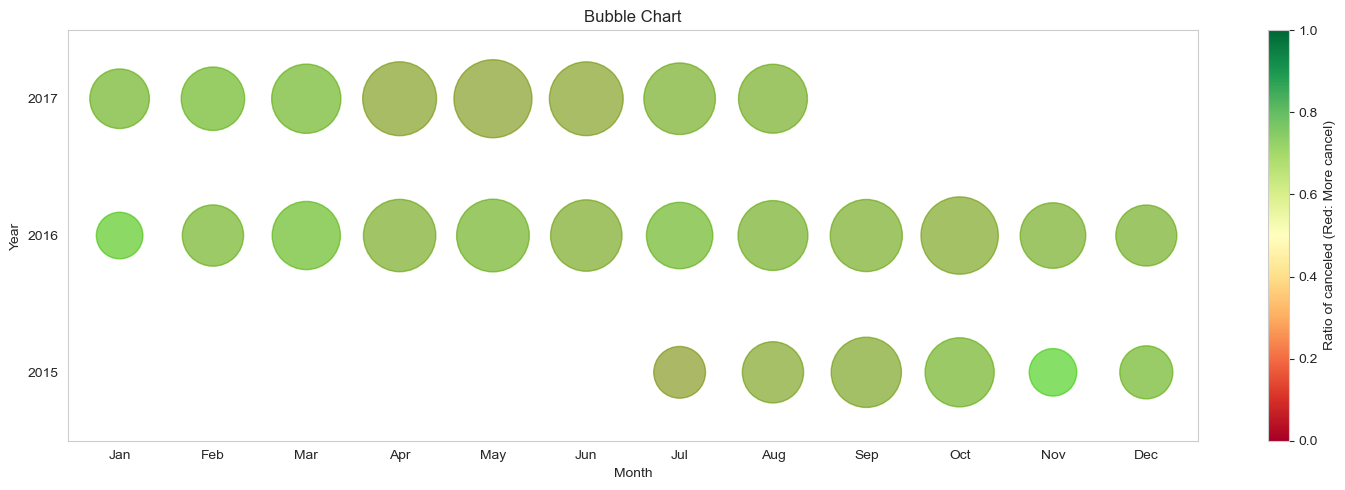

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

df = hotel_booking_dataset[['is_canceled','arrival_date_year', 'arrival_date_month']].copy()
# Convert Month names to numbers
df['MonthNum'] = df['arrival_date_month'].map(lambda x: list(calendar.month_name).index(x))

# Group by Year and Month, then calculate the count of 1s and total count
grouped = df.groupby(['arrival_date_year', 'MonthNum']).agg({
    'is_canceled': ['sum', 'count']
}).reset_index()
grouped.columns = ['Year', 'Month', 'Label1_1', 'Count']
grouped['Label1_2'] = grouped['Count'] - grouped['Label1_1']

# Create bubble chart
fig, ax = plt.subplots(figsize=(15, 5))
for year in grouped['Year'].unique():
    year_data = grouped[grouped['Year'] == year]
    
    # Calculate colors
    colors = year_data.apply(lambda row: (row['Label1_1'] / row['Count'], row['Label1_2'] / row['Count'], 0), axis=1)
    
    # Plot bubbles
    scatter = ax.scatter(year_data['Month'], [year] * len(year_data), s=year_data['Count'] * 0.5, 
                         c=colors.tolist(), alpha=0.6)

# Set axis labels and ticks
ax.set_xticks(range(1, 13))
ax.set_xticklabels(calendar.month_abbr[1:])
ax.set_yticks(grouped['Year'].unique())
ax.set_xlabel('Month')
ax.set_ylabel('Year')

# Remove grid
ax.grid(False)

# Set title
plt.title('Bubble Chart')
# Add color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=ax)
cbar.set_label('Ratio of canceled (Red: More cancel)')
y_min, y_max = grouped['Year'].min(), grouped['Year'].max()
y_padding = 0.5  # Adjust this value as needed
ax.set_ylim(y_min - y_padding, y_max + y_padding)
plt.tight_layout()

plt.show()

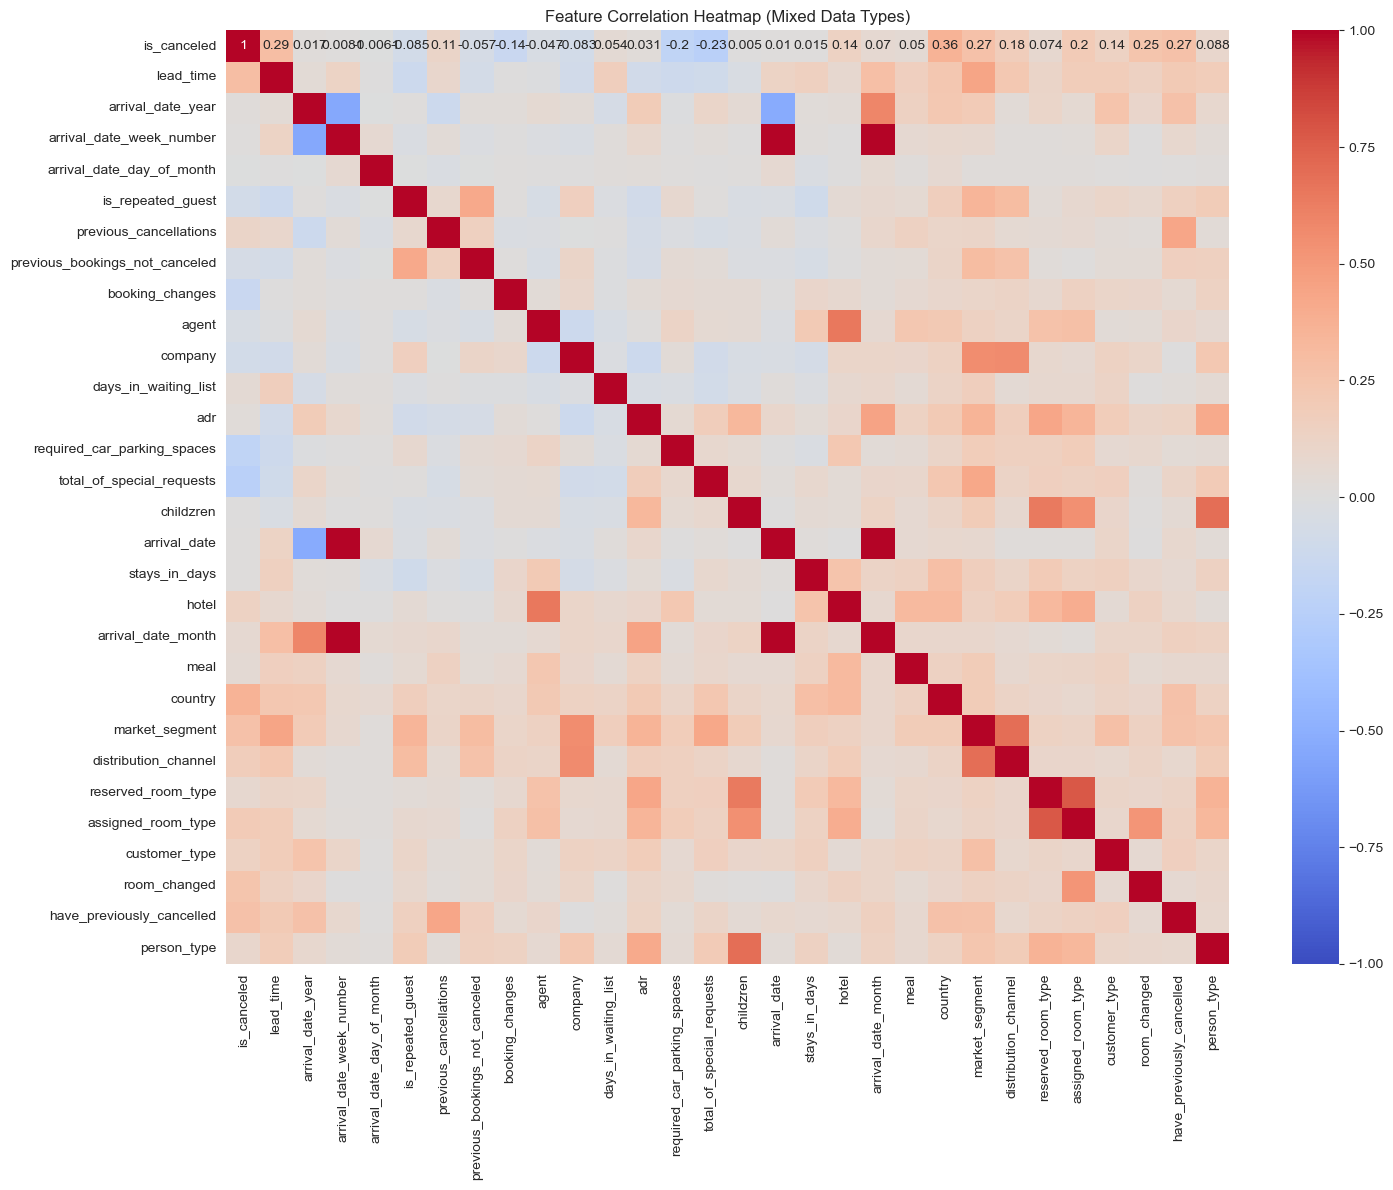

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0, cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurements, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta

# Read the CSV file
df = hotel_booking_dataset_before_onehot.copy()

# Identify numeric and categorical columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

# Initialize the correlation matrix with NaN values
all_columns = pd.Index(numeric_columns.tolist() + categorical_columns.tolist())
corr_matrix = pd.DataFrame(np.nan, index=all_columns, columns=all_columns)

# Fill in numeric correlations
corr_matrix.loc[numeric_columns, numeric_columns] = df[numeric_columns].corr()

# Calculate and fill in correlation ratio for categorical vs numeric
for cat_col in categorical_columns:
    for num_col in numeric_columns:
        correlation = correlation_ratio(df[cat_col], df[num_col])
        corr_matrix.loc[cat_col, num_col] = correlation
        corr_matrix.loc[num_col, cat_col] = correlation

# Calculate and fill in Cramer's V for categorical vs categorical
for i, cat_col1 in enumerate(categorical_columns):
    for cat_col2 in categorical_columns[i:]:
        v = cramers_v(df[cat_col1], df[cat_col2])
        corr_matrix.loc[cat_col1, cat_col2] = v
        corr_matrix.loc[cat_col2, cat_col1] = v

# Fill diagonal with 1.0
np.fill_diagonal(corr_matrix.values, 1.0)

# Create a larger figure for better visibility
plt.figure(figsize=(15, 12))

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

# Set the title
plt.title('Feature Correlation Heatmap (Mixed Data Types)')

# Adjust the layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

# hong的code从这里开始

In [25]:
# change month to int form
hong_hotel_dataset= hotel_booking_dataset.copy()
hong_hotel_dataset['month_int'] = pd.to_datetime(hong_hotel_dataset['arrival_date_month'], format='%B').dt.month

hong_hotel_dataset = hong_hotel_dataset.drop('arrival_date_month', axis=1)

# change person type to int form


type_map = {'couple': 2, 'single': 1, 'family': 3, 'other' :4}
hong_hotel_dataset['person_type'] = hong_hotel_dataset['person_type'].map(type_map)

hong_hotel_dataset



,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,childzren,arrival_date,stays_in_days,room_changed,have_previously_cancelled,person_type,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_Unknown,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,month_int
0,0,0.46,2015,27,1,0,0,0,3,0.00,0.00,0,0.14,0,0,0,0.50,2,False,False,2,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [26]:
feature_names = hong_hotel_dataset.columns.tolist()
feature_names[1:10]

['lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent']

# 1.random forest

In [27]:


# grid search to find the parameter

# for a in range(10, 200, 20):
#     for b in range(10, 80, 10):
#         for c in range(20,100,20):
#             for d in range(5,a//2, 10):
#                 random_forest_dataset = gini_index(hong_hotel_dataset, 0,a)
#                 X_train, X_test, y_train, y_test = train_test_split(random_forest_dataset, hong_hotel_dataset['is_canceled'], test_size=0.1, random_state=42)
#                 X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
#                 random_forest_tree = RandomForest(b, c, X_train, y_train,d)  # max_depth, forest_size, X_train, Y_train, max_features
#                 print(a,b,c,d)
#                 print(f'the train acc :{(random_forest_tree.predict(X_train) == y_train).sum() / len(y_train)}')
#                 print(f'the test acc:{(random_forest_tree.predict(X_test) == y_test).sum() / len(y_test)}')
#                 print('-'*30)

# best parameter
## total feature = 90
## max depth = 40
## forest size = 40
## max feature for each note = 35

In [28]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import tree
from scipy.stats import mode


class RandomForest:
    def __init__(self, max_depth, forest_size, X_train, Y_train, max_features):
        self.max_depth = max_depth
        self.forest_size = forest_size
        self.trees = []

        for _ in range(forest_size):
            clf = tree.DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=self.max_depth,
                                              max_features=max_features)
            clf.fit(X=X_train, y=Y_train)
            self.trees.append(clf)

    def predict(self, X):
        predictions = []
        for the_tree in self.trees:
            predictions.append(the_tree.predict(X))
        predictions = np.stack(predictions)
        result = np.array(mode(predictions, axis=0)[0])
        return result


random_forest_dataset = gini_index(hong_hotel_dataset, 0,90)
X_train, X_test, y_train, y_test = train_test_split(random_forest_dataset, hong_hotel_dataset['is_canceled'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()
random_forest_tree = RandomForest(40, 40, X_train, y_train,35)  # max_depth, forest_size, X_train, Y_train, max_features
print()
print(f'the train acc :{(random_forest_tree.predict(X_train) == y_train).sum() / len(y_train)}')
print(f'the test acc:{(random_forest_tree.predict(X_test) == y_test).sum() / len(y_test)}')

the train acc :0.9942950740337456
the test acc:0.8973950917162241


# 2. ANN

In [29]:
def normalize_selected_features(df, features_to_normalize):
    # Create a copy of the dataframe
    normalized_df = df.copy()
    
    # Normalize only the selected features
    for feature in features_to_normalize:
        if feature in df.columns:
            normalized_df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
        else:
            print(f"Warning: Feature '{feature}' not found in the dataframe.")
    
    return normalized_df

ann_hotel_dataset = normalize_selected_features(hong_hotel_dataset.astype(np.float32), feature_names[1:10])
ann_hotel_dataset

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,childzren,arrival_date,stays_in_days,room_changed,have_previously_cancelled,person_type,hotel_Resort Hotel,meal_FB,meal_HB,meal_SC,meal_Undefined,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DJI,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GEO,country_GGY,country_GHA,country_GIB,country_GLP,country_GNB,country_GRC,country_GTM,country_GUY,country_HKG,country_HND,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KHM,country_KIR,country_KNA,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LCA,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MKD,country_MLI,country_MLT,country_MMR,country_MNE,country_MOZ,country_MRT,country_MUS,country_MWI,country_MYS,country_MYT,country_NAM,country_NCL,country_NGA,country_NIC,country_NLD,country_NOR,country_NPL,country_NZL,country_OMN,country_PAK,country_PAN,country_PER,country_PHL,country_PLW,country_POL,country_PRI,country_PRT,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_UMI,country_URY,country_USA,country_UZB,country_Unknown,country_VEN,country_VGB,country_VNM,country_ZAF,country_ZMB,country_ZWE,month_int
0,0.00,2.23,-1.58,-0.01,-1.69,-0.18,-0.10,-0.09,4.26,-0.70,0.00,0.00,0.14,0.00,0.00,0.00,0.50,2.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(hong_hotel_dataset.drop('is_canceled', axis=1), hong_hotel_dataset['is_canceled'], test_size=0.1, random_state=42)

X_train = torch.from_numpy(X_train.to_numpy().astype(float))
X_train = X_train.double()

X_test = torch.from_numpy(X_test.to_numpy().astype(float))
X_test = X_test.double()

y_train = torch.from_numpy(y_train.to_numpy().astype(float))
y_train = y_train.long()

y_test = torch.from_numpy(y_test.to_numpy().astype(float))
y_test = y_test.long()


print(y_train[:10])



# Define a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, X,y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the ANN model
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleANN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size).double()
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size).double()
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x





# Set up the model, loss function, and optimizer

input_size = len(X_train[1]) # all feature except class
hidden_size = 80
output_size = 2
model = SimpleANN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create dataset and dataloader
train_dataset = SimpleDataset(X_train, y_train)
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


@torch.no_grad()
def check_accuracy():
    model.eval()
    test_output = model(X_test)
    _, predicted = torch.max(test_output, 1)
    out = sum(predicted == y_test) / len(y_test)

    model.train()
    return out.item()

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    if epoch%10 == 0:
        print("acc:",check_accuracy())
        
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

print("Training finished!")






tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1])
acc: 0.37783733010292053
Epoch [1/500], Loss: 0.4662
Epoch [2/500], Loss: 0.2918
Epoch [3/500], Loss: 0.5267
Epoch [4/500], Loss: 0.3340
Epoch [5/500], Loss: 0.4389
Epoch [6/500], Loss: 0.3295
Epoch [7/500], Loss: 0.6281
Epoch [8/500], Loss: 0.5867
Epoch [9/500], Loss: 0.4464


KeyboardInterrupt: 

In [ ]:
torch.save(model, 'ANN_model.pth')